In [1]:
# import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Function to calculate safety stock
def calculate_safety_stock(demand_std, lead_time, lead_time_std, service_level):
    z = stats.norm.ppf(service_level / 100)  # Convert service level percentage to Z-score
    safety_stock = z * np.sqrt((demand_std ** 2 * lead_time) + (demand_std ** 2 * lead_time_std ** 2))
    return safety_stock

# Function to calculate reorder point
def calculate_reorder_point(demand_mean, lead_time, safety_stock):
    return (demand_mean * lead_time) + safety_stock

# Function to calculate inventory cost
def calculate_inventory_cost(safety_stock, holding_cost_per_unit, order_cost, demand_mean, order_quantity):
    holding_cost = safety_stock * holding_cost_per_unit
    ordering_cost = (demand_mean / order_quantity) * order_cost
    return holding_cost + ordering_cost

# Function to calculate stock-out cost
def calculate_stock_out_cost(stock_out_cost_per_unit, safety_stock, demand_mean):
    expected_stockouts = max(0, demand_mean - safety_stock)
    return expected_stockouts * stock_out_cost_per_unit

In [3]:
# User Inputs
demand_mean = 50
demand_std = 10
lead_time = 4
lead_time_std = 1
service_level = 95
order_quantity = 200
holding_cost_per_unit = 0.5
order_cost = 40
stock_out_cost_per_unit = 1.25
simulation_days = 20

In [4]:
# Compute Safety Stock and Reorder Point
safety_stock = calculate_safety_stock(demand_std, lead_time, lead_time_std, service_level)
reorder_point = calculate_reorder_point(demand_mean, lead_time, safety_stock)
inventory_cost = calculate_inventory_cost(safety_stock, holding_cost_per_unit, order_cost, demand_mean, order_quantity)
stock_out_cost = calculate_stock_out_cost(stock_out_cost_per_unit, safety_stock, demand_mean)

/var/folders/13/tb353hv16bg0qsrdngc6r2v40000gn/T/ipykernel_9898/765158832.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


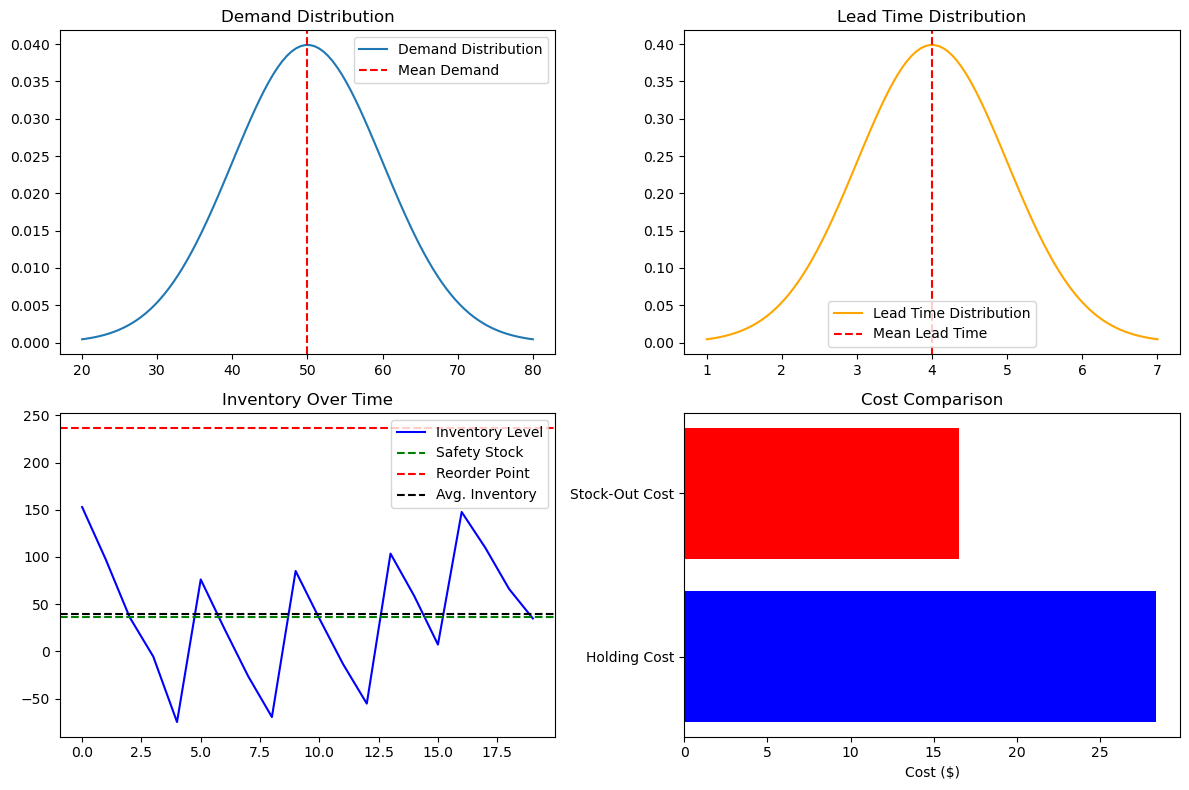

In [5]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Demand Distribution Plot
x = np.linspace(demand_mean - 3*demand_std, demand_mean + 3*demand_std, 100)
y = (1 / (demand_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - demand_mean) / demand_std) ** 2)
axes[0, 0].plot(x, y, label="Demand Distribution")
axes[0, 0].axvline(demand_mean, color='r', linestyle='--', label="Mean Demand")
axes[0, 0].set_title("Demand Distribution")
axes[0, 0].legend()

# Lead Time Distribution Plot
lead_time_x = np.linspace(lead_time - 3*lead_time_std, lead_time + 3*lead_time_std, 100)
lead_time_y = (1 / (lead_time_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((lead_time_x - lead_time) / lead_time_std) ** 2)
axes[0, 1].plot(lead_time_x, lead_time_y, label="Lead Time Distribution", color='orange')
axes[0, 1].axvline(lead_time, color='r', linestyle='--', label="Mean Lead Time")
axes[0, 1].set_title("Lead Time Distribution")
axes[0, 1].legend()

# Inventory Line Plot Simulation with Lead Time
inventory_levels = []
current_inventory = order_quantity
order_pending = False
lead_time_remaining = 0
for day in range(simulation_days):
    daily_demand = np.random.normal(demand_mean, demand_std)
    current_inventory -= daily_demand
    
    if order_pending:
        lead_time_remaining -= 1
        if lead_time_remaining <= 0:
            current_inventory += order_quantity
            order_pending = False
    
    if current_inventory <= reorder_point and not order_pending:
        order_pending = True
        lead_time_remaining = max(1, int(np.random.normal(lead_time, lead_time_std)))
    
    inventory_levels.append(current_inventory)

# calculate average inventory level
average_inventory = sum(inventory_levels) / len(inventory_levels)

axes[1, 0].plot(range(simulation_days), inventory_levels, label="Inventory Level", color='blue')
axes[1, 0].axhline(safety_stock, color='green', linestyle='--', label="Safety Stock")
axes[1, 0].axhline(reorder_point, color='red', linestyle='--', label="Reorder Point")
axes[1, 0].axhline(average_inventory, color='black', linestyle='--', label="Avg. Inventory")
axes[1, 0].set_title("Inventory Over Time")
axes[1, 0].legend()

# Cost Comparison Bar Chart
axes[1, 1].barh(["Holding Cost", "Stock-Out Cost"], [inventory_cost, stock_out_cost], color=['blue', 'red'])
axes[1, 1].set_title("Cost Comparison")
axes[1, 1].set_xlabel("Cost ($)")

plt.tight_layout()

fig.show()